<a href="https://colab.research.google.com/github/Davron030901/PyTorch/blob/main/26_PyTorch_Google_Deep_Dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Googe Deep Dream in PyTorch**

---


In this lesson, we learn to implement the **Google Deep Dream Algorithm** using PyTorch. This method was first introduced by Alexander Mordvintsev from Google in July 2015.

It enables us to provide the 'Deep Dream' effect which produces hallucinogenic-like visuals.

In this tutorial we:

1. Load Modules and pre-trained VGG Network
2. Get the output channels of a layer and run our Deep Dream algorithm
3. Improving Deep Dream by running it on different scales
4. Implement targeted Deep Dream

## **1. Load Modules and pre-trained VGG Network**

Ishlatilayotgan qurilma: cpu


(np.float64(-0.5), np.float64(1199.5), np.float64(1599.5), np.float64(-0.5))

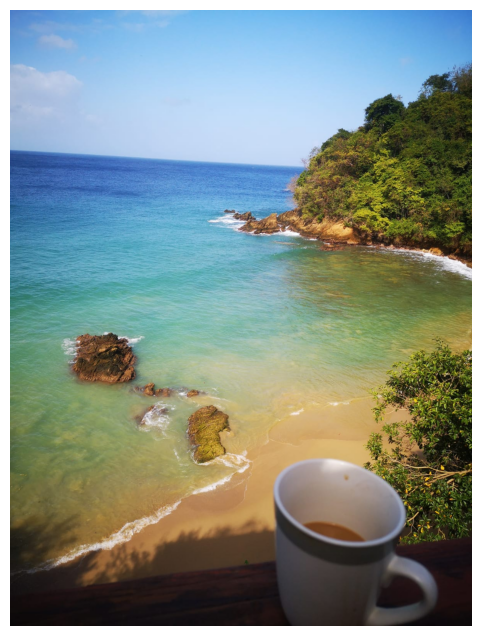

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image, ImageFilter, ImageChops
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# GPU mavjudligini tekshirish va qurilma tanlash (GPU topilmasa CPU ishlatiladi)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Ishlatilayotgan qurilma: {device}")

# VGG16 modelini yuklash - yangi API bilan
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg = vgg.to(device)  # cuda() o'rniga to(device) ishlatiladi
vgg.eval()

# Input rasmni yuklash
url = 'https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Rasmni ko'rsatish
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')

## **2. Get the output channels of a layer**

Get the output channels of a layer and compute the gradients from its L2 norm. Use this data to update the input image, but moving its parameters in the gradient direction (instead of against it). Repeat!

https://www.kaggle.com/sironghuang/understanding-pytorch-hooks

In [ ]:
# Register a hook on the target layer
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# Make gradients calculations from the output channels of the target layer
def get_gradients(net_in, net, layer, out_channels=None):
    net_in = net_in.unsqueeze(0).to(device)
    net_in.requires_grad = True
    net.zero_grad()
    hook = Hook(layer)
    net_out = net(net_in)

    if out_channels is None:
        loss = hook.output[0].norm()
    else:
        loss = hook.output[0][out_channels].norm()

    loss.backward()
    return net_in.grad.data.squeeze()

# Denormalization image transform
denorm = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
])

# Run the Google Deep Dream
def dream(image, net, layer, iterations, lr, out_channels=None):
    image_tensor = transforms.ToTensor()(image)
    image_tensor = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )(image_tensor).to(device)

    for i in range(iterations):
        gradients = get_gradients(image_tensor, net, layer, out_channels)
        image_tensor.data = image_tensor.data + lr * gradients.data

    img_out = image_tensor.detach().cpu()
    img_out = denorm(img_out)
    img_out_np = img_out.numpy().transpose(1,2,0)
    img_out_np = np.clip(img_out_np, 0, 1)
    img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
    return img_out_pil

# Yangilangan, har qanday muhitda ishlaydigan Deep Dream versiyasi
def dream_with_scales(image, net, layer, iterations, lr, scales=8, scale_factor=1.5):
    """
    Multi-scale Deep Dream algoritmi.

    Args:
        image: Boshlang'ich tasvir (PIL Image)
        net: Neyron tarmoq modeli
        layer: Qaysi qatlamdan faollashtirish olinadi
        iterations: Har bir masshtabda necha marta takrorlanadi
        lr: O'rganish tezligi (learning rate)
        scales: Masshtablar soni
        scale_factor: Har bir masshtabning oldingi masshtabga ko'paytirgichi

    Returns:
        Deep Dream ta'siri qo'llanilgan rasm
    """
    # Boshlang'ich rasm o'lchamini saqlash
    orig_size = np.array(image.size)

    # Turli masshtablarda rasm ustida ishlash
    for n in range(-scales+1, 1):
        # Yangi o'lchamni hisoblash
        new_size = orig_size * (scale_factor**n)

        # Rasmni qayta o'lchamlash - Pillow versiyasiga moslashish
        try:
            # Yangi versiyalar uchun (Pillow 9.0.0+)
            image = image.resize(new_size.astype(int), Image.Resampling.LANCZOS)
        except AttributeError:
            try:
                # O'rta versiyalar uchun
                image = image.resize(new_size.astype(int), Image.LANCZOS)
            except AttributeError:
                # Eski versiyalar uchun
                image = image.resize(new_size.astype(int), Image.ANTIALIAS)

        # Dream effektini qo'llash
        image = dream(image, net, layer, iterations, lr)

    # Rasmni boshlang'ich o'lchamga qaytarish
    try:
        image = image.resize(orig_size, Image.Resampling.LANCZOS)
    except AttributeError:
        try:
            image = image.resize(orig_size, Image.LANCZOS)
        except AttributeError:
            image = image.resize(orig_size, Image.ANTIALIAS)

    return image

### **Run Our First Google Deep Dream**

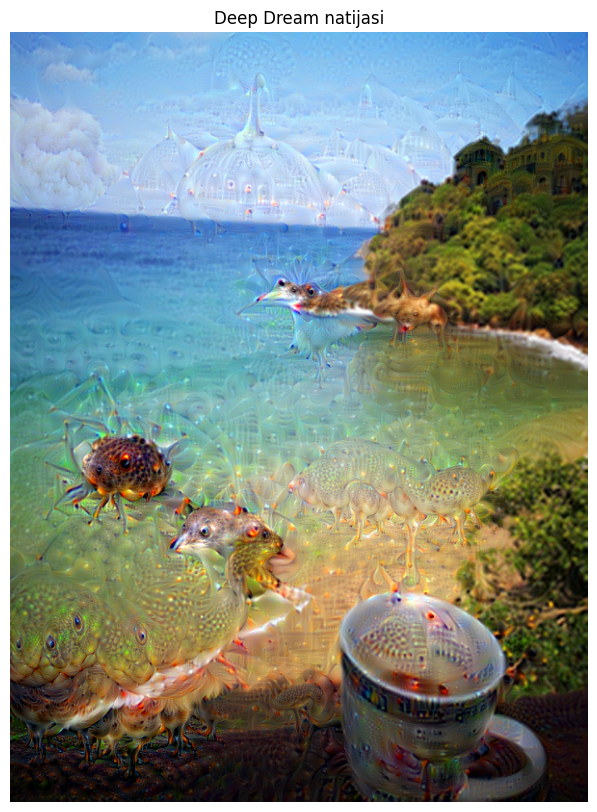

In [ ]:
# VGG16 modelidan qatlamni olish
layer = list(vgg.features.modules())[27]

# Rasmni Deep Dream algoritmi yordamida qayta ishlash
orig_size = np.array(img.size)
img_small = img.copy()

# Rasmni kichiklashtirish (tezroq ishlashi uchun)
new_size = np.array(img.size) * 0.5
try:
    img_small = img_small.resize(new_size.astype(int), Image.Resampling.LANCZOS)
except AttributeError:
    try:
        img_small = img_small.resize(new_size.astype(int), Image.LANCZOS)
    except AttributeError:
        img_small = img_small.resize(new_size.astype(int), Image.ANTIALIAS)

# Deep Dream algoritmini qo'llash
result_img = dream_with_scales(img_small, vgg, layer, iterations=20, lr=0.05, scales=5, scale_factor=1.3)

# Natijani ko'rsatish
plt.figure(figsize=(10, 10))
plt.imshow(result_img)
plt.axis('off')
plt.title("Deep Dream natijasi")
plt.show()

## **Improving Deep Dream**

We see that the patterns have the same scale, and the deep dream effect gets enhanced on the low resolution image.

An update to the prior code is to run the dream function repeatedly, but everytime with the image resized to a different scale.

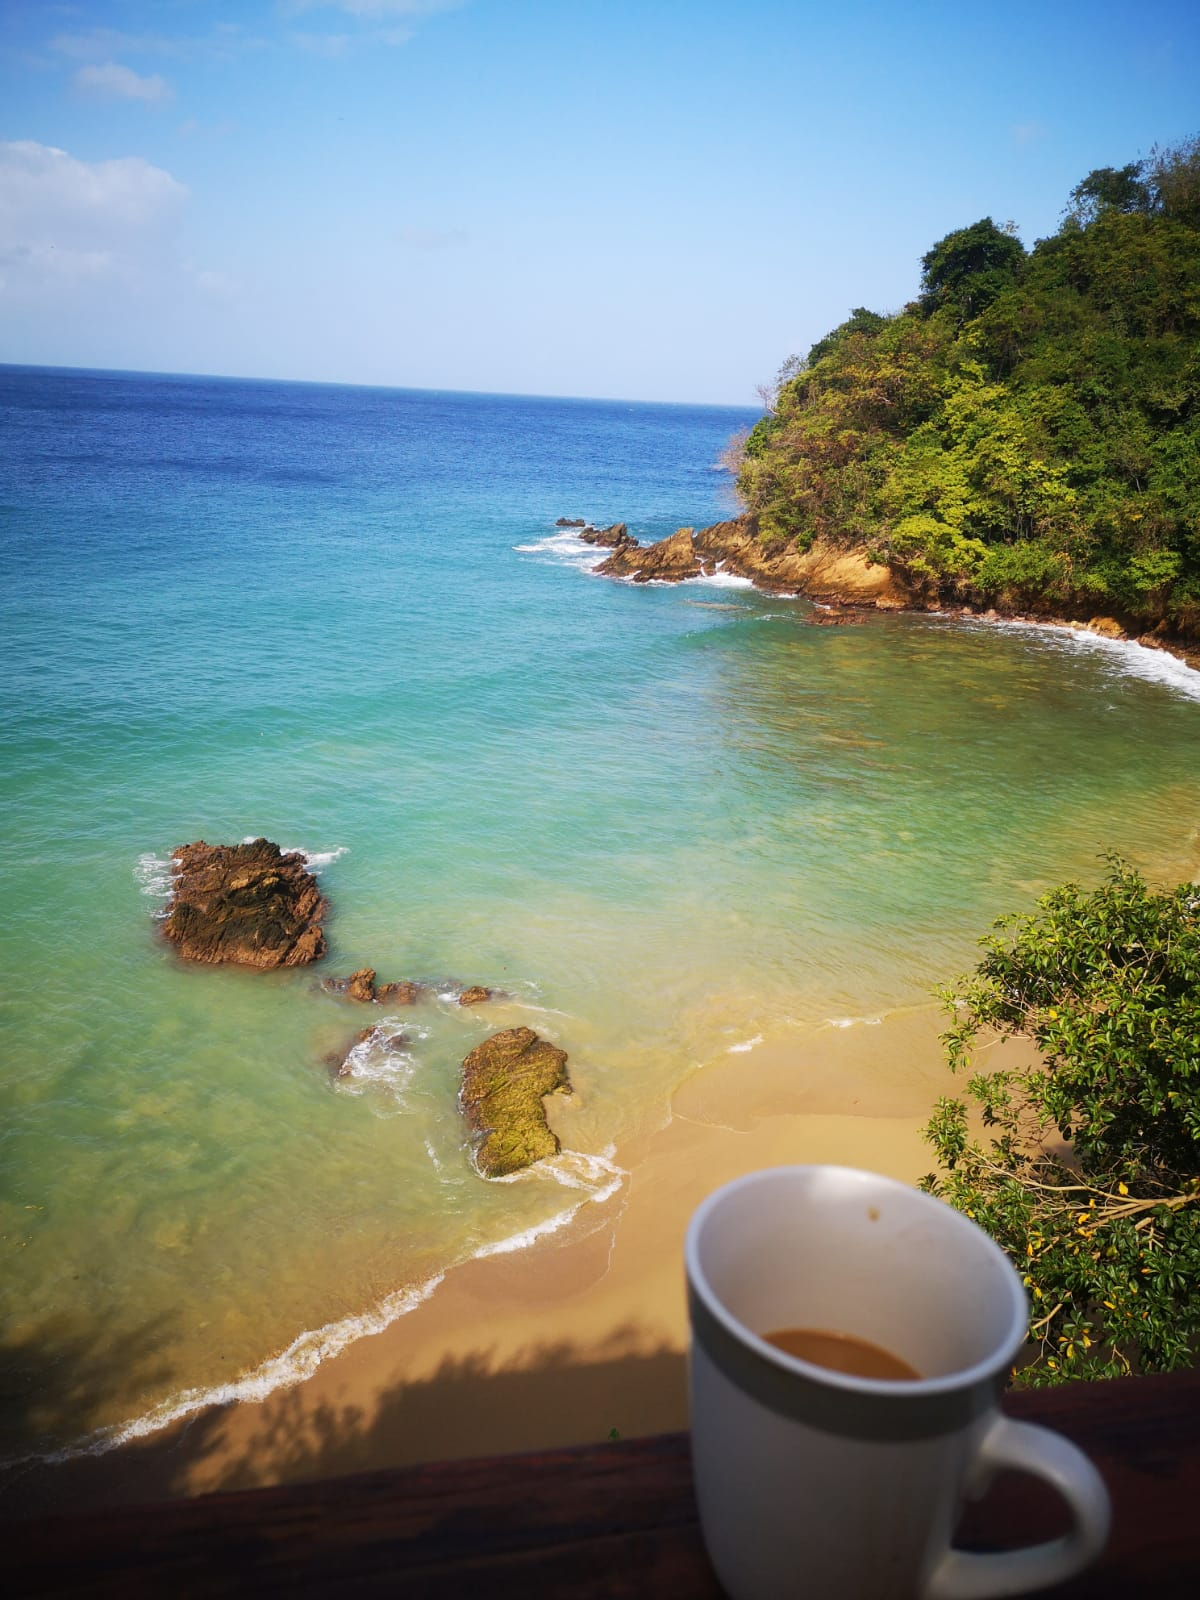

In [ ]:
# Make gradients calculations from the output channels of the target layer.
# Selection of which output channels of the layer can be done
def get_gradients(net_in, net, layer, out_channels = None):
  net_in = net_in.unsqueeze(0).cuda()
  net_in.requires_grad = True
  net.zero_grad()
  hook = Hook(layer)
  net_out = net(net_in)
  if out_channels == None:
    loss = hook.output[0].norm()
  else:
    loss = hook.output[0][out_channels].norm()
  loss.backward()
  return net_in.grad.data.squeeze()

# Function to run the dream. The excesive casts to and from numpy arrays is to make use of the np.roll() function.
# By rolling the image randomly everytime the gradients are computed, we prevent a tile effect artifact from appearing.
def dream(image, net, layer, iterations, lr, out_channels = None):
  image_numpy = np.array(image)
  image_tensor = transforms.ToTensor()(image_numpy)
  image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).cuda()
  denorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
                               ])
  for i in range(iterations):
    roll_x = np.random.randint(image_numpy.shape[0])
    roll_y = np.random.randint(image_numpy.shape[1])
    img_roll = np.roll(np.roll(image_tensor.detach().cpu().numpy().transpose(1,2,0), roll_y, 0), roll_x, 1)
    img_roll_tensor = torch.tensor(img_roll.transpose(2,0,1), dtype = torch.float)
    gradients_np = get_gradients(img_roll_tensor, net, layer, out_channels).detach().cpu().numpy()
    gradients_np = np.roll(np.roll(gradients_np, -roll_y, 1), -roll_x, 2)
    gradients_tensor = torch.tensor(gradients_np).cuda()
    image_tensor.data = image_tensor.data + lr * gradients_tensor.data

  img_out = image_tensor.detach().cpu()
  img_out = denorm(img_out)
  img_out_np = img_out.numpy()
  img_out_np = img_out_np.transpose(1,2,0)
  img_out_np = np.clip(img_out_np, 0, 1)
  img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))
  return img_out_pil

# Input image
url = 'https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
orig_size = np.array(img.size)
new_size = np.array(img.size)*0.5
#img = img.resize(new_size.astype(int))
layer = list( vgg.features.modules() )[27]

from IPython.display import Image as Img

display(img)

## **3.Targeted Deep Dream**

Here we guide the dream, using a target image with features we would like to visualize in our input image.

Ishlatilayotgan qurilma: cpu
VGG16 features modullarining ro'yxati:
Index 0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Index 1: ReLU(inplace=True)
Index 2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Index 3: ReLU(inplace=True)
Index 4: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Index 5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Index 6: ReLU(inplace=True)
Index 7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Index 8: ReLU(inplace=True)
Index 9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Index 10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Index 11: ReLU(inplace=True)
Index 12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Index 13: ReLU(inplace=True)
Index 14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Index 15: ReLU(inplace=True)
Index 16: MaxPool2d(kernel_si

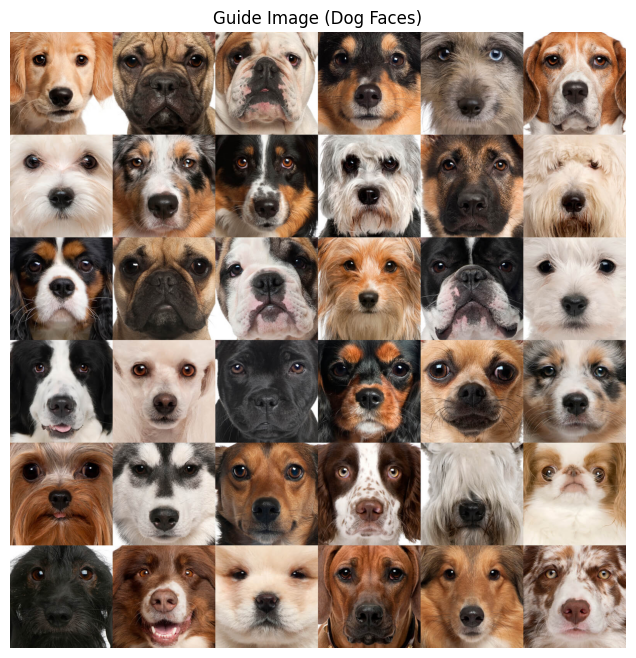

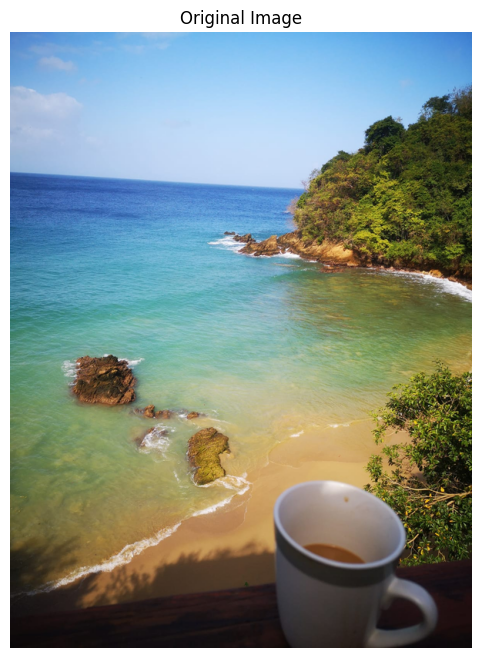

Octave -7 completed
Octave -6 completed
Octave -5 completed
Octave -4 completed
Octave -3 completed
Octave -2 completed
Octave -1 completed


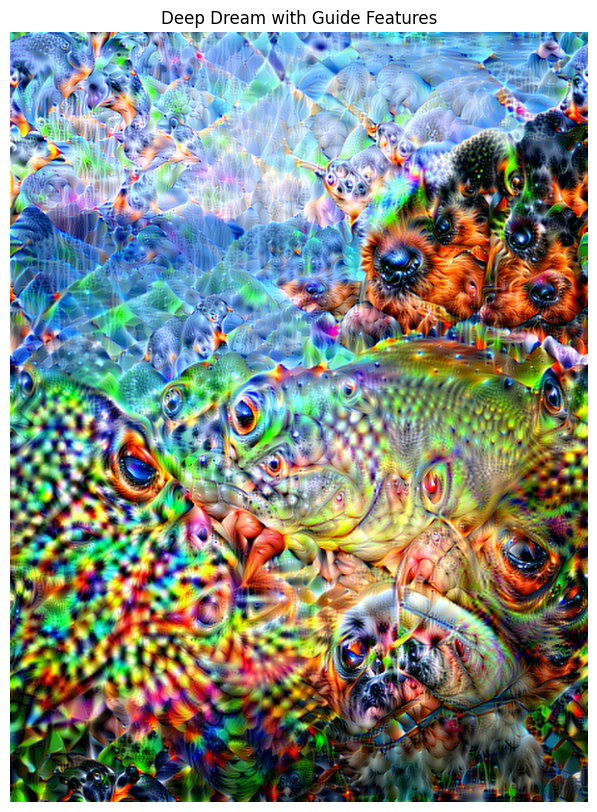

Natija 'deep_dream_guided.jpg' nomli faylda saqlandi


In [ ]:
# GPU mavjudligini tekshirish
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Ishlatilayotgan qurilma: {device}")

# VGG16 modelini yuklash
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg = vgg.to(device)
vgg.eval()

# PIL versiyasiga qarab resampling metodi
if hasattr(Image, 'Resampling'):  # PIL 9.0.0+
    ANTIALIAS = Image.Resampling.LANCZOS
else:  # Eski PIL versiyalari
    ANTIALIAS = Image.ANTIALIAS

# Hook class to get intermediate activations
class Hook():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.output = None

    def hook_fn(self, module, input, output):
        self.output = output

    def close(self):
        self.hook.remove()

# VGG16 modullarini ko'rish
print("VGG16 features modullarining ro'yxati:")
for i, module in enumerate(vgg.features):
    print(f"Index {i}: {module}")

# VGG16 modelida konvolyutsion qatlamlarni topish
conv_layers = []
for i, module in enumerate(vgg.features):
    if isinstance(module, nn.Conv2d):
        conv_layers.append((i, module))

print("\nVGG16 konvolyutsion qatlamlari:")
for i, (idx, layer) in enumerate(conv_layers):
    print(f"Conv layer {i+1}: index {idx}, {layer}")

# Guide features orqali obyekt funksiyasi
def objective_guide(dst, guide_features):
    '''Our objective guide function'''
    # CPU ga ko'chirish va numpy arrayga o'tkazish
    x = dst.data[0].cpu().numpy().copy()
    y = guide_features.data[0].cpu().numpy()
    ch, w, h = x.shape

    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float64)).to(device)
    return result

# Gradientlarni olish
def get_gradients(net_in, net, layer, control=False, guide_features=None):
    net_in = net_in.unsqueeze(0).to(device)
    net_in.requires_grad = True
    net.zero_grad()
    hook = Hook(layer)
    net_out = net(net_in)
    if control:
        params = objective_guide(hook.output, guide_features)[0]
    else:
        params = hook.output[0]
    hook.output[0].backward(params)
    return net_in.grad.data.squeeze()

# Dream algoritmi
def dream(image, net, layer, iterations, lr, control=False, guide_features=None):
    image_numpy = np.array(image)
    image_tensor = transforms.ToTensor()(image_numpy)
    image_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor).to(device)

    # Normalizatsiyani teskari aylantirish
    denorm = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ])

    for i in range(iterations):
        roll_x = np.random.randint(image_numpy.shape[0])
        roll_y = np.random.randint(image_numpy.shape[1])
        img_roll = np.roll(np.roll(image_tensor.detach().cpu().numpy().transpose(1,2,0), roll_y, 0), roll_x, 1)
        img_roll_tensor = torch.tensor(img_roll.transpose(2,0,1), dtype=torch.float).to(device)

        gradients_np = get_gradients(img_roll_tensor, net, layer, control, guide_features).detach().cpu().numpy()
        gradients_np = np.roll(np.roll(gradients_np, -roll_y, 1), -roll_x, 2)

        ratio = np.abs(gradients_np.mean())
        lr_ = lr / ratio if ratio > 0 else lr

        gradients_tensor = torch.tensor(gradients_np).to(device)
        image_tensor.data = image_tensor.data + lr_ * gradients_tensor.data

    img_out = image_tensor.detach().cpu()
    img_out = denorm(img_out)
    img_out_np = img_out.numpy()
    img_out_np = img_out_np.transpose(1,2,0)
    img_out_np = np.clip(img_out_np, 0, 1)
    img_out_pil = Image.fromarray(np.uint8(img_out_np * 255))

    return img_out_pil

# To'g'ri qatlamni tanlash (28 yoki 29 konvolyutsion qatlam, lekin list indeksi o'zgaradi)
# VGG16 da 13 ta konvolyutsion qatlam mavjud, oxirgi qatlamlardan birini olish
# Oxirgi konvolyutsion qatlam (features[30]) bo'lishi mumkin
# -1 bu oxirgi qatlam indeksi
layer_idx = 28  # Agar indeks xato bo'lsa, o'zgartirish mumkin
try:
    layer = vgg.features[layer_idx]
    print(f"Tanlangan qatlam: {layer_idx}, {layer}")
except IndexError:
    # Agar tanlangan qatlam mavjud bo'lmasa, oxirgi konvolyutsion qatlamni olish
    # VGG16 da modullar soni kamroq bo'lishi mumkin
    conv_layers = [(i, m) for i, m in enumerate(vgg.features) if isinstance(m, nn.Conv2d)]
    layer_idx, layer = conv_layers[-1]  # Oxirgi konvolyutsion qatlam
    print(f"Indeks xato. Oxirgi konvolyutsion qatlam tanlanadi: {layer_idx}, {layer}")

# Guide rasm featurelarini olish
url_guide_features = "https://www.allfordogs.org/wp-content/uploads/2018/05/many-dog-faces.jpg"
response = requests.get(url_guide_features)
features_img = Image.open(BytesIO(response.content))
new_size = np.array(features_img.size) * 1.5
features_img = features_img.resize(tuple(new_size.astype(int)), ANTIALIAS)

# Guide rasmni ko'rsatish
plt.figure(figsize=(10, 8))
plt.imshow(features_img)
plt.title("Guide Image (Dog Faces)")
plt.axis('off')
plt.show()

# Guide featurelarni olish
img_np = np.array(features_img)
img_tensor = transforms.ToTensor()(img_np)
# Normalizatsiya
img_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor)
img_tensor = img_tensor.unsqueeze(0).to(device)

hook = Hook(layer)
with torch.no_grad():
    net_out = vgg(img_tensor)
guide_features = hook.output

# Asosiy rasm
url = "https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
new_size = np.array(img.size) * 0.5
img = img.resize(tuple(new_size.astype(int)), ANTIALIAS)
og_size = np.array(img.size)

# Asl rasmni ko'rsatish
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Deep dream effect qo'llash
OCTAVE_SCALE = 1.3
for n in range(-7, 0):
    new_size = og_size * (OCTAVE_SCALE**n)
    img = img.resize(tuple(new_size.astype(int)), ANTIALIAS)
    img = dream(img, vgg, layer, 100, 0.00005, control=True, guide_features=guide_features)
    print(f"Octave {n} completed")

# Asl o'lchamga qaytarish va natijani ko'rsatish
img = img.resize(tuple(og_size.astype(int)), ANTIALIAS)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("Deep Dream with Guide Features")
plt.axis('off')
plt.show()

# Natijani saqlash
img.save('deep_dream_guided.jpg')
print("Natija 'deep_dream_guided.jpg' nomli faylda saqlandi")